In [233]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6


import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar
from utils import get_dataset, average_weights, exp_details

In [234]:
import argparse

parser = argparse.ArgumentParser()
# parser.add_argument('--name', '-n', default='foo', help='foo')
parser.add_argument('--model', type=str, default='mlp', help='model name(mlp or cnn)')
parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset(mnist or cifar)")
parser.add_argument('--epochs', type=int, default=1, help="number of rounds of training(10)")
parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
parser.add_argument('--gpu', default=None, help="To use cuda, set to a specific GPU ID. Default set to use CPU.")
parser.add_argument('--frac', type=float, default=0.1, help='the fraction of clients: C')
parser.add_argument('--local_ep', type=int, default=2, help="the number of local epochs: E")
parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--optimizer', type=str, default='sgd', help="type of optimizer")
parser.add_argument('--verbose', type=int, default=1, help='verbose')
parser.add_argument('--iid', type=int, default=1, help='Default set to IID. Set to 0 for non-IID.')
parser.add_argument('--unequal', type=int, default=0, help='whether to use unequal data splits for  \
                        non-i.i.d setting (use 0 for equal splits)')
# parser.add_argument('--seed', type=int, default=1, help='random seed')

parser.add_argument('--num_clusters', type=int, default=2, help='verbose')
parser.add_argument('--test_acc', type=int, default=75, help='target test accuracy')


# args = parser.parse_args([])
args, _ = parser.parse_known_args()

args
# --dataset=mnist --gpu=0 --iid=0 --epochs=10

Namespace(dataset='mnist', epochs=1, frac=0.1, gpu=None, iid=1, local_bs=10, local_ep=2, lr=0.01, model='mlp', num_classes=10, num_clusters=2, num_users=100, optimizer='sgd', test_acc=75, unequal=0, verbose=1)

In [ ]:
# if __name__ == '__main__':
start_time = time.time()
print("start time: ", start_time)

# define paths
path_project = os.path.abspath('..')
logger = SummaryWriter('../logs')

# args = args_parser()
# exp_details(args)

In [ ]:
if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

In [ ]:
# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(args)

In [ ]:
# Splitting into clusters. FL groups
cluster_size = args.num_users / args.num_clusters
print("Each cluster size: ", cluster_size)

# Cluster 1
A1 = np.arange(cluster_size, dtype=int)
user_groupsA = {k:user_groups[k] for k in A1 if k in user_groups}
print("Size of cluster 1: ", len(user_groupsA))
# Cluster 2
B1 = np.arange(cluster_size, cluster_size+cluster_size, dtype=int)
user_groupsB = {k:user_groups[k] for k in B1 if k in user_groups}
print("Size of cluster 2: ", len(user_groupsB))

In [ ]:
# Check that clusters are all different
print(user_groupsA.keys())
print(user_groupsB.keys())

In [ ]:
# BUILD MODEL
def build_model(args, train_dataset):
    if args.model == 'cnn':
        # Convolutional neural network
        if args.dataset == 'mnist':
            global_model = CNNMnist(args=args)
        elif args.dataset == 'fmnist':
            global_model = CNNFashion_Mnist(args=args)
        elif args.dataset == 'cifar':
            global_model = CNNCifar(args=args)

    elif args.model == 'mlp':
        # Multi-layer preceptron
        img_size = train_dataset[0][0].shape
        len_in = 1
        for x in img_size:
            len_in *= x
            global_model = MLP(dim_in=len_in, dim_hidden=200,
                               dim_out=args.num_classes)
    else:
        exit('Error: unrecognized model')
        
    return global_model

In [ ]:
# MODEL PARAM SUMMARY
global_model = build_model(args, train_dataset)
pytorch_total_params = sum(p.numel() for p in global_model.parameters())
print(pytorch_total_params)

from torchsummary import summary

summary(global_model, (1, 28, 28))
global_model.parameters()

In [ ]:
# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

In [ ]:
# Set the cluster models to train and send it to device.
cluster_modelA = build_model(args, train_dataset)
cluster_modelA.to(device)
cluster_modelA.train()
# copy weights
cluster_modelA_weights = cluster_modelA.state_dict()

# Set the cluster models to train and send it to device.
cluster_modelB = build_model(args, train_dataset)
cluster_modelB.to(device)
cluster_modelB.train()
# copy weights
cluster_modelB_weights = cluster_modelA.state_dict()

In [ ]:
# Defining the training function
def fl_train(args, train_dataset, cluster_global_model, cluster, usergrp, epochs):
#     print(args)
    
#     # Set the model to train and send it to device.
#     cluster_global_model = build_model(args, train_dataset)
#     cluster_global_model.to(device)
#     cluster_global_model.train()

#     # copy weights
#     cluster_global_weights = cluster_global_model.state_dict()
        
    cluster_train_loss, cluster_train_accuracy = [], []
    cluster_val_acc_list, cluster_net_list = [], []
    cluster_cv_loss, cluster_cv_acc = [], []
#     print_every = 1
    cluster_val_loss_pre, counter = 0, 0
    
#     for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cluster_local_weights, cluster_local_losses = [], []
#         print(f'\n | Cluster Training Round : {epoch+1} |\n')

        cluster_global_model.train()
        m = max(int(args.frac * len(cluster)), 1)
        idxs_users = np.random.choice(cluster, m, replace=False)


        for idx in idxs_users:
            cluster_local_model = LocalUpdate(args=args, dataset=train_dataset, idxs=usergrp[idx], logger=logger)
            cluster_w, cluster_loss = cluster_local_model.update_weights(model=copy.deepcopy(cluster_global_model), global_round=epoch)
            cluster_local_weights.append(copy.deepcopy(cluster_w))
            cluster_local_losses.append(copy.deepcopy(cluster_loss))
            print('| Global Round : {} | User : {} | \tLoss: {:.6f}'.format(epoch, idx, cluster_loss))
            
        # averaging global weights
        cluster_global_weights = average_weights(cluster_local_weights)

        # update global weights
        cluster_global_model.load_state_dict(cluster_global_weights)

        cluster_loss_avg = sum(cluster_local_losses) / len(cluster_local_losses)
        cluster_train_loss.append(cluster_loss_avg)

#         # Calculate avg training accuracy over all users at every epoch
#         cluster_list_acc, cluster_list_loss = [], []
#         cluster_global_model.eval()
        
#         for c in range(len(cluster)):
#             cluster_local_model = LocalUpdate(args=args, dataset=train_dataset,
#                                       idxs=usergrp[idx], logger=logger)
#             cluster_acc, cluster_loss = cluster_local_model.inference(model=cluster_global_model)
#             cluster_list_acc.append(cluster_acc)
#             cluster_list_loss.append(cluster_loss)
#         cluster_train_accuracy.append(sum(cluster_list_acc)/len(cluster_list_acc))
    
#     return cluster_global_model, cluster_train_loss #cluster_global_weights, cluster_loss_avg, cluster_train_accuracy 
    return cluster_global_weights, cluster_loss_avg
    
# A_model, A_weights, A_losses, A_trainacc = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)    
# A_model, A_trainloss = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
# A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)

### Main training

In [ ]:
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 1
val_loss_pre, counter = 0, 0
# Add
testacc_check, epoch = 0, 0

# for epoch in tqdm(range(args.epochs)):
while testacc_check < args.test_acc:
    local_weights, local_losses, local_accuracies= [], [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')
    
    # ============== TRAIN ==============
    global_model.train()
    
    # Cluster A
    A_weights, A_losses = fl_train(args, train_dataset, cluster_modelA, A1, user_groupsA, 2)
    local_weights.append(copy.deepcopy(A_weights))
    local_losses.append(copy.deepcopy(A_losses))
    
    # Cluster B
    B_weights, B_losses = fl_train(args, train_dataset, cluster_modelB, B1, user_groupsB, 2)
    local_weights.append(copy.deepcopy(B_weights))
    local_losses.append(copy.deepcopy(B_losses))
    
    
    # averaging global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
    # ============== EVAL ============== 
    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(args.num_users):
        local_model = LocalUpdate(args=args, dataset=train_dataset,
                                  idxs=user_groups[c], logger=logger)
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))
    # Add
    testacc_check = 100*train_accuracy[-1] 
    
    epoch = epoch + 1
    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
#         print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f"\nAvg Training Stats after {epoch} global rounds:")
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
#         print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1][0]))
    

print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

In [ ]:
# Test inference after completion of training
test_acc, test_loss = test_inference(args, global_model, test_dataset)

print(f' \n Results after {args.epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

# Saving the objects train_loss and train_accuracy:
file_name = '../save/objects/{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}].pkl'.\
    format(args.dataset, args.model, epoch, args.frac, args.iid,
           args.local_ep, args.local_bs)

with open(file_name, 'wb') as f:
    pickle.dump([train_loss, train_accuracy], f)



In [336]:
import pickle

filename = "[13]HFL4_mnist_cnn_100_lr[0.01]_C[0.1]_iid[1]_E[1]_B[10]"
with open(r"../save/objects/" + filename + ".pkl", "rb") as input_file:
        data = pickle.load(input_file)
        
# print(data)
trloss = data[0]
tracc = data[1]
print(len(trloss))
(len(tracc))

100


100

In [337]:
tracc[-1]

0.9888333333333338

In [338]:
# using enumerate() + next() to find index of first element just greater than 80%
testacc = 0.97
res = next(x for x, val in enumerate(tracc) if val >= testacc) 

# printing result 
print ("The number of global training round just greater than " + str(testacc*100) + "% : " + str(res+1)) 

The number of global training round just greater than 97.0% : 5


/home/wesleyjtann/miniconda3/envs/fl_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

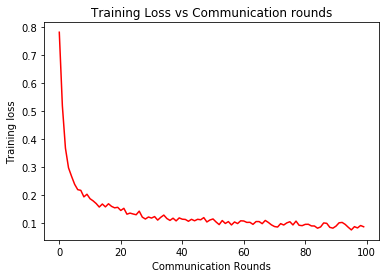

In [315]:
# PLOTTING (optional)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

# Plot Loss curve
plt.figure()
plt.title('Training Loss vs Communication rounds')
# plt.plot(range(len(train_loss)), train_loss, color='r')
plt.plot(range(len(trloss)), trloss, color='r')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_loss.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

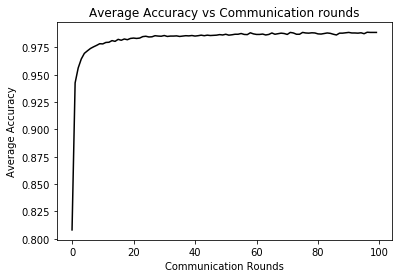

In [316]:
# Plot Average Accuracy vs Communication rounds
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
# plt.plot(range(len(train_accuracy)), train_accuracy, color='k')
plt.plot(range(len(tracc)), tracc, color='k')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
# plt.savefig('../save/fed_{}_{}_{}_C[{}]_iid[{}]_E[{}]_B[{}]_acc.png'.
#             format(args.dataset, args.model, args.epochs, args.frac,
#                    args.iid, args.local_ep, args.local_bs))
plt.show

55

In [174]:
train_dataset, test_dataset, user_groupsold = get_dataset(args)
keys =  list(user_groupsold.keys())
random.shuffle(keys)
user_groups = dict()
for key in keys:
    user_groups.update({key:user_groupsold[key]})
# print(user_groups.keys()) 
keylist = list(user_groups.keys())
print("keylist: ", keylist)

Dataset: MNIST IID
keylist:  [67, 70, 32, 69, 22, 38, 85, 15, 60, 64, 27, 49, 71, 59, 40, 86, 94, 39, 65, 81, 12, 1, 10, 23, 13, 20, 73, 77, 29, 92, 25, 78, 97, 17, 80, 95, 82, 41, 90, 44, 62, 8, 34, 37, 24, 46, 56, 21, 83, 93, 14, 9, 28, 33, 36, 19, 54, 5, 45, 30, 35, 91, 18, 2, 11, 16, 76, 75, 51, 0, 43, 79, 74, 52, 31, 88, 99, 66, 50, 42, 6, 72, 53, 68, 58, 7, 63, 57, 48, 98, 55, 47, 61, 87, 96, 26, 3, 4, 89, 84]


In [186]:
clustersize=25
A1 = keylist[:clustersize]
len(A1)

25

In [249]:
train_dataset, test_dataset, user_groups = get_dataset(args)
user_groups

Dataset: MNIST IID


{0: {31,
  253,
  286,
  340,
  591,
  730,
  843,
  941,
  1107,
  1242,
  1339,
  1359,
  1563,
  1676,
  1785,
  1876,
  1928,
  2031,
  2243,
  2438,
  2441,
  2472,
  2497,
  2512,
  2635,
  2688,
  2720,
  2843,
  2871,
  2972,
  2981,
  3120,
  3201,
  3239,
  3303,
  3523,
  3598,
  3637,
  3676,
  3724,
  3748,
  3878,
  3918,
  3970,
  4133,
  4222,
  4258,
  4565,
  4792,
  4957,
  5090,
  5158,
  5248,
  5366,
  5378,
  5573,
  5658,
  5775,
  5846,
  5878,
  5928,
  5959,
  6056,
  6312,
  6385,
  6421,
  6483,
  6487,
  6575,
  6750,
  6802,
  6941,
  7085,
  7139,
  7227,
  7228,
  7585,
  7707,
  7824,
  8091,
  8446,
  8448,
  8458,
  8492,
  8695,
  8788,
  8799,
  8849,
  9027,
  9044,
  9250,
  9255,
  9353,
  9445,
  9659,
  9704,
  9716,
  9823,
  9875,
  9995,
  10143,
  10272,
  10282,
  10329,
  10435,
  10451,
  10803,
  10872,
  10960,
  11054,
  11168,
  11251,
  11491,
  11581,
  11719,
  11967,
  11979,
  12187,
  12290,
  12292,
  12342,
  12402,
  12516,